### References

**Book:**
- Deep Learning with Python, Second Edition
  - Book by François Chollet
  - François Chollet is a French software engineer and artificial intelligence researcher currently working at Google. Chollet is the creator of the Keras deep-learning library, released in 2015, and a main contributor to the TensorFlow machine learning framework.


### Beyond text classification: Sequence-to-sequence learning

A sequence-to-sequence model takes a sequence as input (often a sentence or paragraph) and translates it into a different sequence. This is the task at the heart of many of the most successful applications of NLP:

- Machine translation—Convert a paragraph in a source language to its equivalent in a target language.
- Text summarization—Convert a long document to a shorter version that retains the most important information.
- Question answering—Convert an input question into its answer.
- Chatbots—Convert a dialogue prompt into a reply to this prompt, or convert the history of a conversation into the next reply in the conversation.
- Text generation—Convert a text prompt into a paragraph that completes the prompt.

The general template behind sequence-to-sequence models is described as follows During training,
- An encoder model turns the source sequence into an intermediate representation.
- A decoder is trained to predict the next token i in the target sequence by looking
at both previous tokens (0 to i - 1) and the encoded source sequence.

During inference, we don’t have access to the target sequence—we’re trying to predict it from scratch. We’ll have to generate it one token at a time:
1. We obtain the encoded source sequence from the encoder.
2. The decoder starts by looking at the encoded source sequence as well as an initial “seed” token (i.e. the string "[start]"), and uses them to predict the first real token in the sequence.
3. The predicted sequence so far is fed back into the decoder, which generates the next token, and so on, until it generates a stop token (such as the string "[end]").

Everything we’ve learned so far can be repurposed to build this new kind of model.

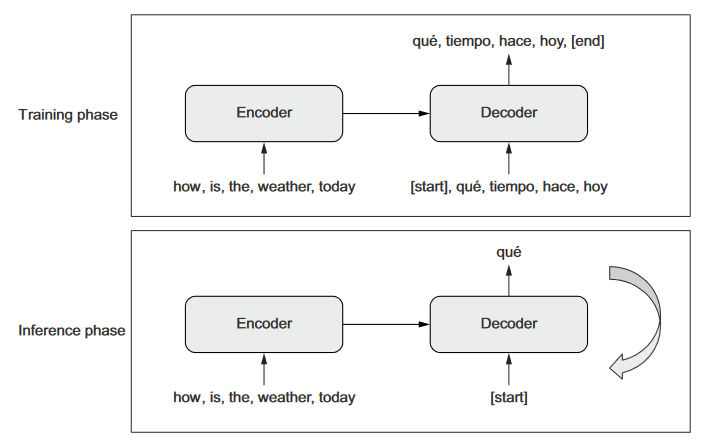

### A machine translation example

We’ll demonstrate sequence-to-sequence modeling on a machine translation task.

Machine translation is precisely what Transformer was developed for! We’ll start with a recurrent sequence model, and we’ll follow up with the full Transformer architecture.

We’ll be working with an English-to-Spanish translation dataset available at www.manythings.org/anki/

Let’s download it:

`!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip`

`!unzip -q spa-eng.zip`

The text file contains one example per line: an English sentence, followed by a tab character, followed by the corresponding Spanish sentence. 

Let’s parse this file.

In [2]:
# Data file
text_file = "spa-eng/spa.txt"

# Reading the file
# Split the data by \n (separate each line) and consider from start split (start line) to second last split (last line)
# Last split will be a blank character
with open(text_file, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]

# Store text pair (english, spanish with start and end tags)
text_pairs = []

# Iterate over the lines in the file
for line in lines:
    # Each line contains an English phrase and its Spanish translation, tab-separated
    english, spanish = line.split("\t")

    # Append and prepend start and end tags to the target sequence (spanish)
    spanish = "[start] " + spanish + " [end]"
    
    # Appending english and corresponding modified spanish pair as tuple
    text_pairs.append((english, spanish))

In [3]:
import random

In [5]:
print(random.choice(text_pairs))

('Mary took out the eggs one by one.', '[start] Mary sacó los huevos uno por uno. [end]')


In [ ]:
# Let’s shuffle them and split them into the usual training, validation, and test sets

# Shuffle
random.shuffle(text_pairs)

# Validation sample => 15% of all
num_val_samples = int(0.15 * len(text_pairs))

# Train sample => all - (2 * (Validation sample)) => (all - 30%) => 70% of all
num_train_samples = len(text_pairs) - 2 * num_val_samples

# Train pairs => start to num_train_samples => 70%
train_pairs = text_pairs[:num_train_samples]

# Validation pairs => num_train_samples to (num_train_samples + num_val_samples) => 15%
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]

# Test pairs => (num_train_samples + num_val_samples) till end => Rest 15%
test_pairs = text_pairs[num_train_samples + num_val_samples:]